# Texts

In [6]:
text_linear="""Linear model, 1 samples got a PSNR of 10.35
Linear model, 2 samples got a PSNR of 10.32
Linear model, 3 samples got a PSNR of 10.01
Linear model, 4 samples got a PSNR of 10.34
Linear model, 5 samples got a PSNR of 11.47
Linear model, 6 samples got a PSNR of 10.66
Linear model, 7 samples got a PSNR of 10.93
Linear model, 8 samples got a PSNR of 10.91
Linear model, 9 samples got a PSNR of 11.19
Linear model, 10 samples got a PSNR of 10.78
Linear model, 11 samples got a PSNR of 11.53
Linear model, 12 samples got a PSNR of 11.80
Linear model, 13 samples got a PSNR of 11.67
Linear model, 14 samples got a PSNR of 11.39
Linear model, 16 samples got a PSNR of 12.65
Linear model, 17 samples got a PSNR of 12.02
Linear model, 19 samples got a PSNR of 11.81
Linear model, 21 samples got a PSNR of 12.19
Linear model, 23 samples got a PSNR of 12.29
Linear model, 25 samples got a PSNR of 12.63
Linear model, 28 samples got a PSNR of 12.12
Linear model, 31 samples got a PSNR of 11.89
Linear model, 34 samples got a PSNR of 12.55
Linear model, 37 samples got a PSNR of 13.28
Linear model, 41 samples got a PSNR of 13.16
Linear model, 45 samples got a PSNR of 13.18
Linear model, 49 samples got a PSNR of 12.83
Linear model, 54 samples got a PSNR of 12.85
Linear model, 59 samples got a PSNR of 13.43
Linear model, 65 samples got a PSNR of 13.70
Linear model, 72 samples got a PSNR of 13.83
Linear model, 79 samples got a PSNR of 14.36
Linear model, 86 samples got a PSNR of 14.08
Linear model, 95 samples got a PSNR of 14.41
Linear model, 104 samples got a PSNR of 14.34
Linear model, 114 samples got a PSNR of 14.56
Linear model, 126 samples got a PSNR of 14.65
Linear model, 138 samples got a PSNR of 14.78
Linear model, 151 samples got a PSNR of 14.87
Linear model, 166 samples got a PSNR of 14.85
Linear model, 183 samples got a PSNR of 15.11
Linear model, 200 samples got a PSNR of 15.19
Linear model, 220 samples got a PSNR of 15.40
Linear model, 242 samples got a PSNR of 15.59
Linear model, 265 samples got a PSNR of 15.64
Linear model, 291 samples got a PSNR of 15.84
Linear model, 319 samples got a PSNR of 15.79
Linear model, 351 samples got a PSNR of 15.89
Linear model, 385 samples got a PSNR of 16.10
Linear model, 422 samples got a PSNR of 16.29
Linear model, 464 samples got a PSNR of 16.37
Linear model, 509 samples got a PSNR of 16.41
Linear model, 559 samples got a PSNR of 16.55
Linear model, 613 samples got a PSNR of 16.88
Linear model, 673 samples got a PSNR of 16.86
Linear model, 739 samples got a PSNR of 16.98
Linear model, 811 samples got a PSNR of 17.18
Linear model, 890 samples got a PSNR of 17.30
Linear model, 977 samples got a PSNR of 17.51
Linear model, 1072 samples got a PSNR of 17.58
Linear model, 1176 samples got a PSNR of 17.70
Linear model, 1291 samples got a PSNR of 17.68
Linear model, 1417 samples got a PSNR of 18.02
Linear model, 1555 samples got a PSNR of 18.18
Linear model, 1707 samples got a PSNR of 18.38
Linear model, 1873 samples got a PSNR of 18.59
Linear model, 2056 samples got a PSNR of 18.75
Linear model, 2257 samples got a PSNR of 19.06
Linear model, 2477 samples got a PSNR of 19.24
Linear model, 2718 samples got a PSNR of 19.31
Linear model, 2983 samples got a PSNR of 19.72
Linear model, 3274 samples got a PSNR of 20.07
Linear model, 3593 samples got a PSNR of 20.26
Linear model, 3944 samples got a PSNR of 20.46
Linear model, 4328 samples got a PSNR of 20.73
Linear model, 4750 samples got a PSNR of 21.00
Linear model, 5214 samples got a PSNR of 21.30
Linear model, 5722 samples got a PSNR of 21.59
Linear model, 6280 samples got a PSNR of 21.74
Linear model, 6892 samples got a PSNR of 22.14
Linear model, 7564 samples got a PSNR of 22.38
Linear model, 8302 samples got a PSNR of 22.65
Linear model, 9111 samples got a PSNR of 22.80
Linear model, 10000 samples got a PSNR of 23.09
"""

text_neural="""Neural model, 1 samples got a PSNR of 11.26
Neural model, 2 samples got a PSNR of 11.11
Neural model, 3 samples got a PSNR of 11.16
Neural model, 4 samples got a PSNR of 11.39
Neural model, 5 samples got a PSNR of 11.11
Neural model, 6 samples got a PSNR of 11.42
Neural model, 7 samples got a PSNR of 11.49
Neural model, 8 samples got a PSNR of 11.47
Neural model, 9 samples got a PSNR of 11.56
Neural model, 10 samples got a PSNR of 11.61
Neural model, 11 samples got a PSNR of 11.83
Neural model, 12 samples got a PSNR of 11.51
Neural model, 13 samples got a PSNR of 11.87
Neural model, 14 samples got a PSNR of 11.86
Neural model, 16 samples got a PSNR of 11.71
Neural model, 17 samples got a PSNR of 11.90
Neural model, 19 samples got a PSNR of 11.93
Neural model, 21 samples got a PSNR of 11.95
Neural model, 23 samples got a PSNR of 12.22
Neural model, 25 samples got a PSNR of 12.09
Neural model, 28 samples got a PSNR of 12.50
Neural model, 31 samples got a PSNR of 12.35
Neural model, 34 samples got a PSNR of 12.55
Neural model, 37 samples got a PSNR of 12.41
Neural model, 41 samples got a PSNR of 12.48
Neural model, 45 samples got a PSNR of 12.98
Neural model, 49 samples got a PSNR of 13.40
Neural model, 54 samples got a PSNR of 13.65
Neural model, 59 samples got a PSNR of 13.49
Neural model, 65 samples got a PSNR of 12.57
Neural model, 72 samples got a PSNR of 13.09
Neural model, 79 samples got a PSNR of 13.23
Neural model, 86 samples got a PSNR of 13.36
Neural model, 95 samples got a PSNR of 13.32
Neural model, 104 samples got a PSNR of 13.47
Neural model, 114 samples got a PSNR of 13.70
Neural model, 126 samples got a PSNR of 13.84
Neural model, 138 samples got a PSNR of 13.81
Neural model, 151 samples got a PSNR of 13.96
Neural model, 166 samples got a PSNR of 14.08
Neural model, 183 samples got a PSNR of 14.25
Neural model, 200 samples got a PSNR of 14.28
Neural model, 220 samples got a PSNR of 14.47
Neural model, 242 samples got a PSNR of 14.63
Neural model, 265 samples got a PSNR of 14.70
Neural model, 291 samples got a PSNR of 14.93
Neural model, 319 samples got a PSNR of 15.02
Neural model, 351 samples got a PSNR of 15.07
Neural model, 385 samples got a PSNR of 14.82
Neural model, 422 samples got a PSNR of 15.48
Neural model, 464 samples got a PSNR of 15.54
Neural model, 509 samples got a PSNR of 15.74
Neural model, 559 samples got a PSNR of 15.96
Neural model, 613 samples got a PSNR of 16.06
Neural model, 673 samples got a PSNR of 16.19
Neural model, 739 samples got a PSNR of 16.42
Neural model, 811 samples got a PSNR of 16.64
Neural model, 890 samples got a PSNR of 16.83
Neural model, 977 samples got a PSNR of 17.03
Neural model, 1072 samples got a PSNR of 17.31
Neural model, 1176 samples got a PSNR of 17.60
Neural model, 1291 samples got a PSNR of 17.70
Neural model, 1417 samples got a PSNR of 18.11
Neural model, 1555 samples got a PSNR of 18.30
Neural model, 1707 samples got a PSNR of 18.67
Neural model, 1873 samples got a PSNR of 19.12
Neural model, 2056 samples got a PSNR of 19.38
Neural model, 2257 samples got a PSNR of 19.99
Neural model, 2477 samples got a PSNR of 20.31
Neural model, 2718 samples got a PSNR of 20.75
Neural model, 2983 samples got a PSNR of 21.35
Neural model, 3274 samples got a PSNR of 21.62
Neural model, 3593 samples got a PSNR of 22.19
Neural model, 3944 samples got a PSNR of 22.61
Neural model, 4328 samples got a PSNR of 23.03
Neural model, 4750 samples got a PSNR of 23.40
Neural model, 5214 samples got a PSNR of 23.57
Neural model, 5722 samples got a PSNR of 23.91
Neural model, 6280 samples got a PSNR of 24.11
Neural model, 6892 samples got a PSNR of 24.49
Neural model, 7564 samples got a PSNR of 24.61
Neural model, 8302 samples got a PSNR of 24.73
Neural model, 9111 samples got a PSNR of 24.76
Neural model, 10000 samples got a PSNR of 24.82
"""

text_conv="""Conv model, 1 samples got a PSNR of 21.46
Conv model, 2 samples got a PSNR of 27.07
Conv model, 3 samples got a PSNR of 24.67
Conv model, 4 samples got a PSNR of 27.48
Conv model, 5 samples got a PSNR of 28.08
Conv model, 6 samples got a PSNR of 26.16
Conv model, 7 samples got a PSNR of 25.49
Conv model, 8 samples got a PSNR of 28.46
Conv model, 9 samples got a PSNR of 25.99
Conv model, 10 samples got a PSNR of 26.90
Conv model, 11 samples got a PSNR of 26.32
Conv model, 12 samples got a PSNR of 27.36
Conv model, 13 samples got a PSNR of 28.01
Conv model, 14 samples got a PSNR of 28.75
Conv model, 16 samples got a PSNR of 27.91
Conv model, 17 samples got a PSNR of 27.48
Conv model, 19 samples got a PSNR of 28.83
Conv model, 21 samples got a PSNR of 28.13
Conv model, 23 samples got a PSNR of 28.92
Conv model, 25 samples got a PSNR of 26.68
Conv model, 28 samples got a PSNR of 26.40
Conv model, 31 samples got a PSNR of 28.43
Conv model, 34 samples got a PSNR of 28.98
Conv model, 37 samples got a PSNR of 29.37
Conv model, 41 samples got a PSNR of 29.26
Conv model, 45 samples got a PSNR of 28.32
Conv model, 49 samples got a PSNR of 28.14
Conv model, 54 samples got a PSNR of 29.91
Conv model, 59 samples got a PSNR of 29.78
Conv model, 65 samples got a PSNR of 22.58
Conv model, 72 samples got a PSNR of 27.36
Conv model, 79 samples got a PSNR of 29.18
Conv model, 86 samples got a PSNR of 29.24
Conv model, 95 samples got a PSNR of 29.50
Conv model, 104 samples got a PSNR of 29.52
Conv model, 114 samples got a PSNR of 30.15
Conv model, 126 samples got a PSNR of 29.05
Conv model, 138 samples got a PSNR of 29.83
Conv model, 151 samples got a PSNR of 29.14
Conv model, 166 samples got a PSNR of 30.15
Conv model, 183 samples got a PSNR of 29.88
Conv model, 200 samples got a PSNR of 29.92
Conv model, 220 samples got a PSNR of 29.89
Conv model, 242 samples got a PSNR of 30.13
Conv model, 265 samples got a PSNR of 28.28
Conv model, 291 samples got a PSNR of 29.88
Conv model, 319 samples got a PSNR of 30.27
Conv model, 351 samples got a PSNR of 29.82
Conv model, 385 samples got a PSNR of 29.83
Conv model, 422 samples got a PSNR of 29.98
Conv model, 464 samples got a PSNR of 29.91
Conv model, 509 samples got a PSNR of 29.72
Conv model, 559 samples got a PSNR of 29.75
Conv model, 613 samples got a PSNR of 29.52
Conv model, 673 samples got a PSNR of 29.95
Conv model, 739 samples got a PSNR of 30.17
Conv model, 811 samples got a PSNR of 30.15
Conv model, 890 samples got a PSNR of 30.04
Conv model, 977 samples got a PSNR of 30.27
Conv model, 1072 samples got a PSNR of 30.07
Conv model, 1176 samples got a PSNR of 30.22
Conv model, 1291 samples got a PSNR of 30.35
Conv model, 1417 samples got a PSNR of 30.26
Conv model, 1555 samples got a PSNR of 29.84
Conv model, 1707 samples got a PSNR of 29.91
Conv model, 1873 samples got a PSNR of 29.84
Conv model, 2056 samples got a PSNR of 30.06
Conv model, 2257 samples got a PSNR of 30.05
Conv model, 2477 samples got a PSNR of 29.81
Conv model, 2718 samples got a PSNR of 30.08
Conv model, 2983 samples got a PSNR of 30.08
Conv model, 3274 samples got a PSNR of 29.79
Conv model, 3593 samples got a PSNR of 29.91
Conv model, 3944 samples got a PSNR of 29.90
Conv model, 4328 samples got a PSNR of 29.61
Conv model, 4750 samples got a PSNR of 30.12
Conv model, 5214 samples got a PSNR of 30.31
Conv model, 5722 samples got a PSNR of 30.07
Conv model, 6280 samples got a PSNR of 30.33
Conv model, 6892 samples got a PSNR of 29.94
Conv model, 7564 samples got a PSNR of 30.11
Conv model, 8302 samples got a PSNR of 29.82
Conv model, 9111 samples got a PSNR of 30.06
Conv model, 10000 samples got a PSNR of 29.90
"""

text_zeroshot="""Zeroshot model, 2 samples got a PSNR of 10.474342468190192
Zeroshot model, 4 samples got a PSNR of 10.436643597483634
Zeroshot model, 6 samples got a PSNR of 10.689134286785126
Zeroshot model, 8 samples got a PSNR of 11.712419185733795
Zeroshot model, 10 samples got a PSNR of 11.384831460285186
Zeroshot model, 12 samples got a PSNR of 11.442377526760101
Zeroshot model, 14 samples got a PSNR of 11.763907818841934
Zeroshot model, 16 samples got a PSNR of 11.442707687950135
Zeroshot model, 28 samples got a PSNR of 12.464193607187271
Zeroshot model, 34 samples got a PSNR of 12.61997381362915
Zeroshot model, 54 samples got a PSNR of 13.198072327423096
Zeroshot model, 72 samples got a PSNR of 13.551559515237809
Zeroshot model, 86 samples got a PSNR of 13.536291838979722
Zeroshot model, 104 samples got a PSNR of 14.551812079954148
Zeroshot model, 114 samples got a PSNR of 14.578982863903045
Zeroshot model, 126 samples got a PSNR of 14.706224149370193
Zeroshot model, 138 samples got a PSNR of 14.649336433649063
Zeroshot model, 166 samples got a PSNR of 15.252265959358215
Zeroshot model, 200 samples got a PSNR of 15.467857165956497
Zeroshot model, 220 samples got a PSNR of 15.683368610477448
Zeroshot model, 242 samples got a PSNR of 15.784724367761612
Zeroshot model, 422 samples got a PSNR of 16.886640251350403
Zeroshot model, 464 samples got a PSNR of 17.170437191581726
Zeroshot model, 890 samples got a PSNR of 19.105783526802064
Zeroshot model, 1072 samples got a PSNR of 19.681016798210145
Zeroshot model, 1176 samples got a PSNR of 20.01771463718414
Zeroshot model, 2056 samples got a PSNR of 22.359933672237396
Zeroshot model, 2718 samples got a PSNR of 23.610636276054382
Zeroshot model, 3274 samples got a PSNR of 24.42201575393677
Zeroshot model, 3944 samples got a PSNR of 25.243875001335145
Zeroshot model, 4328 samples got a PSNR of 25.593914499473573
Zeroshot model, 4750 samples got a PSNR of 25.963398430633546
Zeroshot model, 5214 samples got a PSNR of 26.30425527572632
Zeroshot model, 6280 samples got a PSNR of 26.962707159996032
Zeroshot model, 8302 samples got a PSNR of 27.94483180370331
Zeroshot model, 10000 samples got a PSNR of 28.315617350769042"""

In [7]:
text_conv = """Conv model, 1 samples got a PSNR of 17.79
Conv model, 2 samples got a PSNR of 23.75
Conv model, 3 samples got a PSNR of 23.74
Conv model, 4 samples got a PSNR of 27.83
Conv model, 5 samples got a PSNR of 24.39
Conv model, 6 samples got a PSNR of 26.68
Conv model, 7 samples got a PSNR of 27.19
Conv model, 8 samples got a PSNR of 26.45
Conv model, 9 samples got a PSNR of 25.78
Conv model, 10 samples got a PSNR of 27.62
Conv model, 11 samples got a PSNR of 25.09
Conv model, 12 samples got a PSNR of 28.38
Conv model, 13 samples got a PSNR of 26.52
Conv model, 14 samples got a PSNR of 27.54
Conv model, 16 samples got a PSNR of 28.48
Conv model, 17 samples got a PSNR of 27.68
Conv model, 19 samples got a PSNR of 26.09
Conv model, 21 samples got a PSNR of 27.51
Conv model, 23 samples got a PSNR of 29.22
Conv model, 25 samples got a PSNR of 28.38
Conv model, 28 samples got a PSNR of 27.92
Conv model, 31 samples got a PSNR of 29.10
Conv model, 34 samples got a PSNR of 29.60
Conv model, 37 samples got a PSNR of 28.55
Conv model, 41 samples got a PSNR of 27.50
Conv model, 45 samples got a PSNR of 29.09
Conv model, 49 samples got a PSNR of 29.61
Conv model, 54 samples got a PSNR of 29.13
Conv model, 59 samples got a PSNR of 29.36
Conv model, 65 samples got a PSNR of 24.13
Conv model, 72 samples got a PSNR of 27.28
Conv model, 79 samples got a PSNR of 28.88
Conv model, 86 samples got a PSNR of 28.41
Conv model, 95 samples got a PSNR of 29.84
Conv model, 104 samples got a PSNR of 28.95
Conv model, 114 samples got a PSNR of 29.95
Conv model, 126 samples got a PSNR of 29.70
Conv model, 138 samples got a PSNR of 29.42
Conv model, 151 samples got a PSNR of 28.77
Conv model, 166 samples got a PSNR of 29.54
Conv model, 183 samples got a PSNR of 30.32
Conv model, 200 samples got a PSNR of 29.60
Conv model, 220 samples got a PSNR of 29.77
Conv model, 242 samples got a PSNR of 29.19
Conv model, 265 samples got a PSNR of 29.58
Conv model, 291 samples got a PSNR of 30.43
Conv model, 319 samples got a PSNR of 29.80
Conv model, 351 samples got a PSNR of 30.33
Conv model, 385 samples got a PSNR of 29.15
Conv model, 422 samples got a PSNR of 30.41
Conv model, 464 samples got a PSNR of 30.30
Conv model, 509 samples got a PSNR of 30.05
Conv model, 559 samples got a PSNR of 30.23
Conv model, 613 samples got a PSNR of 30.19
Conv model, 673 samples got a PSNR of 29.90
Conv model, 739 samples got a PSNR of 30.44
Conv model, 811 samples got a PSNR of 30.06
Conv model, 890 samples got a PSNR of 30.47
Conv model, 977 samples got a PSNR of 29.90
Conv model, 1072 samples got a PSNR of 29.95
Conv model, 1176 samples got a PSNR of 30.23
Conv model, 1291 samples got a PSNR of 29.84
Conv model, 1417 samples got a PSNR of 30.11
Conv model, 1555 samples got a PSNR of 30.33
Conv model, 1707 samples got a PSNR of 30.45
Conv model, 1873 samples got a PSNR of 30.05
Conv model, 2056 samples got a PSNR of 30.05
Conv model, 2257 samples got a PSNR of 29.99
Conv model, 2477 samples got a PSNR of 29.77
Conv model, 2718 samples got a PSNR of 29.90
Conv model, 2983 samples got a PSNR of 30.11
Conv model, 3274 samples got a PSNR of 29.72
Conv model, 3593 samples got a PSNR of 29.82
Conv model, 3944 samples got a PSNR of 30.24
Conv model, 4328 samples got a PSNR of 30.08
Conv model, 4750 samples got a PSNR of 30.06
Conv model, 5214 samples got a PSNR of 30.13
Conv model, 5722 samples got a PSNR of 30.37
Conv model, 6280 samples got a PSNR of 29.58
Conv model, 6892 samples got a PSNR of 30.60
Conv model, 7564 samples got a PSNR of 30.23
Conv model, 8302 samples got a PSNR of 29.93
Conv model, 9111 samples got a PSNR of 30.22
Conv model, 10000 samples got a PSNR of 29.90
"""

In [10]:
text_linear = """Linear model, 1 samples got a PSNR of 10.88
Linear model, 2 samples got a PSNR of 10.74
Linear model, 3 samples got a PSNR of 9.95
Linear model, 4 samples got a PSNR of 9.95
Linear model, 5 samples got a PSNR of 10.21
Linear model, 6 samples got a PSNR of 10.45
Linear model, 7 samples got a PSNR of 10.17
Linear model, 8 samples got a PSNR of 10.01
Linear model, 9 samples got a PSNR of 10.55
Linear model, 10 samples got a PSNR of 10.58
Linear model, 11 samples got a PSNR of 10.98
Linear model, 12 samples got a PSNR of 11.13
Linear model, 13 samples got a PSNR of 11.07
Linear model, 14 samples got a PSNR of 10.99
Linear model, 16 samples got a PSNR of 11.05
Linear model, 17 samples got a PSNR of 11.18
Linear model, 19 samples got a PSNR of 11.06
Linear model, 21 samples got a PSNR of 11.29
Linear model, 23 samples got a PSNR of 11.42
Linear model, 25 samples got a PSNR of 11.88
Linear model, 28 samples got a PSNR of 11.86
Linear model, 31 samples got a PSNR of 11.80
Linear model, 34 samples got a PSNR of 12.05
Linear model, 37 samples got a PSNR of 11.90
Linear model, 41 samples got a PSNR of 11.90
Linear model, 45 samples got a PSNR of 12.07
Linear model, 49 samples got a PSNR of 12.43
Linear model, 54 samples got a PSNR of 12.46
Linear model, 59 samples got a PSNR of 12.51
Linear model, 65 samples got a PSNR of 12.59
Linear model, 72 samples got a PSNR of 12.86
Linear model, 79 samples got a PSNR of 13.06
Linear model, 86 samples got a PSNR of 13.16
Linear model, 95 samples got a PSNR of 13.31
Linear model, 104 samples got a PSNR of 13.40
Linear model, 114 samples got a PSNR of 13.43
Linear model, 126 samples got a PSNR of 13.71
Linear model, 138 samples got a PSNR of 13.81
Linear model, 151 samples got a PSNR of 13.97
Linear model, 166 samples got a PSNR of 14.07
Linear model, 183 samples got a PSNR of 14.21
Linear model, 200 samples got a PSNR of 14.40
Linear model, 220 samples got a PSNR of 14.54
Linear model, 242 samples got a PSNR of 14.65
Linear model, 265 samples got a PSNR of 14.78
Linear model, 291 samples got a PSNR of 14.89
Linear model, 319 samples got a PSNR of 15.06
Linear model, 351 samples got a PSNR of 15.20
Linear model, 385 samples got a PSNR of 15.32
Linear model, 422 samples got a PSNR of 15.50
Linear model, 464 samples got a PSNR of 15.62
Linear model, 509 samples got a PSNR of 15.74
Linear model, 559 samples got a PSNR of 15.89
Linear model, 613 samples got a PSNR of 16.08
Linear model, 673 samples got a PSNR of 16.25
Linear model, 739 samples got a PSNR of 16.39
Linear model, 811 samples got a PSNR of 16.55
Linear model, 890 samples got a PSNR of 16.71
Linear model, 977 samples got a PSNR of 16.88
Linear model, 1072 samples got a PSNR of 17.05
Linear model, 1176 samples got a PSNR of 17.23
Linear model, 1291 samples got a PSNR of 17.44
Linear model, 1417 samples got a PSNR of 17.66
Linear model, 1555 samples got a PSNR of 17.84
Linear model, 1707 samples got a PSNR of 18.04
Linear model, 1873 samples got a PSNR of 18.27
Linear model, 2056 samples got a PSNR of 18.48
Linear model, 2257 samples got a PSNR of 18.73
Linear model, 2477 samples got a PSNR of 19.00
Linear model, 2718 samples got a PSNR of 19.26
Linear model, 2983 samples got a PSNR of 19.54
Linear model, 3274 samples got a PSNR of 19.80
Linear model, 3593 samples got a PSNR of 20.08
Linear model, 3944 samples got a PSNR of 20.37
Linear model, 4328 samples got a PSNR of 20.63
Linear model, 4750 samples got a PSNR of 20.89
Linear model, 5214 samples got a PSNR of 21.19
Linear model, 5722 samples got a PSNR of 21.43
Linear model, 6280 samples got a PSNR of 21.70
Linear model, 6892 samples got a PSNR of 21.97
Linear model, 7564 samples got a PSNR of 22.26
Linear model, 8302 samples got a PSNR of 22.53
Linear model, 9111 samples got a PSNR of 22.76
Linear model, 10000 samples got a PSNR of 22.96"""

text_neural = """Neural model, 1 samples got a PSNR of 11.21
Neural model, 2 samples got a PSNR of 11.22
Neural model, 3 samples got a PSNR of 11.34
Neural model, 4 samples got a PSNR of 11.36
Neural model, 5 samples got a PSNR of 11.41
Neural model, 6 samples got a PSNR of 11.52
Neural model, 7 samples got a PSNR of 11.50
Neural model, 8 samples got a PSNR of 11.64
Neural model, 9 samples got a PSNR of 11.69
Neural model, 10 samples got a PSNR of 11.65
Neural model, 11 samples got a PSNR of 11.74
Neural model, 12 samples got a PSNR of 11.82
Neural model, 13 samples got a PSNR of 11.90
Neural model, 14 samples got a PSNR of 11.92
Neural model, 16 samples got a PSNR of 11.94
Neural model, 17 samples got a PSNR of 12.00
Neural model, 19 samples got a PSNR of 12.08
Neural model, 21 samples got a PSNR of 12.16
Neural model, 23 samples got a PSNR of 12.24
Neural model, 25 samples got a PSNR of 12.28
Neural model, 28 samples got a PSNR of 12.36
Neural model, 31 samples got a PSNR of 12.37
Neural model, 34 samples got a PSNR of 12.60
Neural model, 37 samples got a PSNR of 12.56
Neural model, 41 samples got a PSNR of 12.92
Neural model, 45 samples got a PSNR of 13.38
Neural model, 49 samples got a PSNR of 13.51
Neural model, 54 samples got a PSNR of 13.72
Neural model, 59 samples got a PSNR of 13.77
Neural model, 65 samples got a PSNR of 12.39
Neural model, 72 samples got a PSNR of 13.11
Neural model, 79 samples got a PSNR of 13.20
Neural model, 86 samples got a PSNR of 13.30
Neural model, 95 samples got a PSNR of 13.41
Neural model, 104 samples got a PSNR of 13.50
Neural model, 114 samples got a PSNR of 13.56
Neural model, 126 samples got a PSNR of 14.31
Neural model, 138 samples got a PSNR of 13.71
Neural model, 151 samples got a PSNR of 13.98
Neural model, 166 samples got a PSNR of 14.10
Neural model, 183 samples got a PSNR of 14.26
Neural model, 200 samples got a PSNR of 14.25
Neural model, 220 samples got a PSNR of 14.47
Neural model, 242 samples got a PSNR of 14.58
Neural model, 265 samples got a PSNR of 14.58
Neural model, 291 samples got a PSNR of 14.80
Neural model, 319 samples got a PSNR of 15.00
Neural model, 351 samples got a PSNR of 15.13
Neural model, 385 samples got a PSNR of 14.98
Neural model, 422 samples got a PSNR of 15.42
Neural model, 464 samples got a PSNR of 15.51
Neural model, 509 samples got a PSNR of 15.73
Neural model, 559 samples got a PSNR of 15.88
Neural model, 613 samples got a PSNR of 16.05
Neural model, 673 samples got a PSNR of 16.20
Neural model, 739 samples got a PSNR of 16.39
Neural model, 811 samples got a PSNR of 16.58
Neural model, 890 samples got a PSNR of 16.81
Neural model, 977 samples got a PSNR of 17.07
Neural model, 1072 samples got a PSNR of 17.32
Neural model, 1176 samples got a PSNR of 17.56
Neural model, 1291 samples got a PSNR of 17.75
Neural model, 1417 samples got a PSNR of 18.11
Neural model, 1555 samples got a PSNR of 18.39
Neural model, 1707 samples got a PSNR of 18.70
Neural model, 1873 samples got a PSNR of 19.09
Neural model, 2056 samples got a PSNR of 19.36
Neural model, 2257 samples got a PSNR of 19.98
Neural model, 2477 samples got a PSNR of 20.36
Neural model, 2718 samples got a PSNR of 20.88
Neural model, 2983 samples got a PSNR of 21.29
Neural model, 3274 samples got a PSNR of 21.74
Neural model, 3593 samples got a PSNR of 22.14
Neural model, 3944 samples got a PSNR of 22.54
Neural model, 4328 samples got a PSNR of 22.94
Neural model, 4750 samples got a PSNR of 23.20
Neural model, 5214 samples got a PSNR of 23.66
Neural model, 5722 samples got a PSNR of 23.86
Neural model, 6280 samples got a PSNR of 24.12
Neural model, 6892 samples got a PSNR of 24.49
Neural model, 7564 samples got a PSNR of 24.45
Neural model, 8302 samples got a PSNR of 24.80
Neural model, 9111 samples got a PSNR of 24.91
Neural model, 10000 samples got a PSNR of 24.87"""

text_conv = """Conv model, 1 samples got a PSNR of 18.44
Conv model, 2 samples got a PSNR of 23.15
Conv model, 3 samples got a PSNR of 22.21
Conv model, 4 samples got a PSNR of 22.74
Conv model, 5 samples got a PSNR of 23.86
Conv model, 6 samples got a PSNR of 24.52
Conv model, 7 samples got a PSNR of 25.72
Conv model, 8 samples got a PSNR of 25.55
Conv model, 9 samples got a PSNR of 27.15
Conv model, 10 samples got a PSNR of 26.93
Conv model, 11 samples got a PSNR of 26.77
Conv model, 12 samples got a PSNR of 27.08
Conv model, 13 samples got a PSNR of 27.56
Conv model, 14 samples got a PSNR of 27.86
Conv model, 16 samples got a PSNR of 28.03
Conv model, 17 samples got a PSNR of 28.74
Conv model, 19 samples got a PSNR of 28.94
Conv model, 21 samples got a PSNR of 28.89
Conv model, 23 samples got a PSNR of 28.88
Conv model, 25 samples got a PSNR of 28.55
Conv model, 28 samples got a PSNR of 28.80
Conv model, 31 samples got a PSNR of 29.20
Conv model, 34 samples got a PSNR of 29.35
Conv model, 37 samples got a PSNR of 29.15
Conv model, 41 samples got a PSNR of 29.32
Conv model, 45 samples got a PSNR of 29.42
Conv model, 49 samples got a PSNR of 29.70
Conv model, 54 samples got a PSNR of 29.52
Conv model, 59 samples got a PSNR of 29.77
Conv model, 65 samples got a PSNR of 18.97
Conv model, 72 samples got a PSNR of 28.29
Conv model, 79 samples got a PSNR of 29.24
Conv model, 86 samples got a PSNR of 29.41
Conv model, 95 samples got a PSNR of 29.85
Conv model, 104 samples got a PSNR of 29.80
Conv model, 114 samples got a PSNR of 29.76
Conv model, 126 samples got a PSNR of 30.15
Conv model, 138 samples got a PSNR of 29.69
Conv model, 151 samples got a PSNR of 29.91
Conv model, 166 samples got a PSNR of 29.77
Conv model, 183 samples got a PSNR of 30.29
Conv model, 200 samples got a PSNR of 29.59
Conv model, 220 samples got a PSNR of 30.04
Conv model, 242 samples got a PSNR of 29.85
Conv model, 265 samples got a PSNR of 29.30
Conv model, 291 samples got a PSNR of 29.88
Conv model, 319 samples got a PSNR of 29.98
Conv model, 351 samples got a PSNR of 29.59
Conv model, 385 samples got a PSNR of 28.96
Conv model, 422 samples got a PSNR of 29.90
Conv model, 464 samples got a PSNR of 30.07
Conv model, 509 samples got a PSNR of 29.96
Conv model, 559 samples got a PSNR of 30.07
Conv model, 613 samples got a PSNR of 29.96
Conv model, 673 samples got a PSNR of 29.93
Conv model, 739 samples got a PSNR of 30.01
Conv model, 811 samples got a PSNR of 30.06
Conv model, 890 samples got a PSNR of 30.08
Conv model, 977 samples got a PSNR of 29.87
Conv model, 1072 samples got a PSNR of 29.97
Conv model, 1176 samples got a PSNR of 29.62
Conv model, 1291 samples got a PSNR of 29.99
Conv model, 1417 samples got a PSNR of 29.88
Conv model, 1555 samples got a PSNR of 30.26
Conv model, 1707 samples got a PSNR of 29.82
Conv model, 1873 samples got a PSNR of 29.91
Conv model, 2056 samples got a PSNR of 29.93
Conv model, 2257 samples got a PSNR of 29.54
Conv model, 2477 samples got a PSNR of 30.19
Conv model, 2718 samples got a PSNR of 29.75
Conv model, 2983 samples got a PSNR of 30.19
Conv model, 3274 samples got a PSNR of 30.18
Conv model, 3593 samples got a PSNR of 30.20
Conv model, 3944 samples got a PSNR of 30.56
Conv model, 4328 samples got a PSNR of 30.26
Conv model, 4750 samples got a PSNR of 30.19
Conv model, 5214 samples got a PSNR of 30.55
Conv model, 5722 samples got a PSNR of 30.25
Conv model, 6280 samples got a PSNR of 30.13
Conv model, 6892 samples got a PSNR of 30.16
Conv model, 7564 samples got a PSNR of 29.86
Conv model, 8302 samples got a PSNR of 29.74
Conv model, 9111 samples got a PSNR of 29.92
Conv model, 10000 samples got a PSNR of 29.98"""

In [14]:
text_conv = """Conv model, 1 samples got a PSNR of 14.75
Conv model, 2 samples got a PSNR of 24.90
Conv model, 3 samples got a PSNR of 26.01
Conv model, 4 samples got a PSNR of 25.22
Conv model, 5 samples got a PSNR of 25.47
Conv model, 6 samples got a PSNR of 25.68
Conv model, 7 samples got a PSNR of 25.54
Conv model, 8 samples got a PSNR of 25.49
Conv model, 9 samples got a PSNR of 24.90
Conv model, 10 samples got a PSNR of 24.83
Conv model, 11 samples got a PSNR of 25.16
Conv model, 12 samples got a PSNR of 25.45
Conv model, 13 samples got a PSNR of 25.90
Conv model, 14 samples got a PSNR of 25.52
Conv model, 16 samples got a PSNR of 25.26
Conv model, 17 samples got a PSNR of 25.43
Conv model, 19 samples got a PSNR of 24.93
Conv model, 21 samples got a PSNR of 25.37
Conv model, 23 samples got a PSNR of 26.05
Conv model, 25 samples got a PSNR of 25.83
Conv model, 28 samples got a PSNR of 25.68
Conv model, 31 samples got a PSNR of 25.62
Conv model, 34 samples got a PSNR of 26.11
Conv model, 37 samples got a PSNR of 26.27
Conv model, 41 samples got a PSNR of 26.34
Conv model, 45 samples got a PSNR of 26.56
Conv model, 49 samples got a PSNR of 26.94
Conv model, 54 samples got a PSNR of 27.18
Conv model, 59 samples got a PSNR of 27.35
Conv model, 65 samples got a PSNR of 27.02
Conv model, 72 samples got a PSNR of 27.24
Conv model, 79 samples got a PSNR of 28.04
Conv model, 86 samples got a PSNR of 28.61
Conv model, 95 samples got a PSNR of 29.28
Conv model, 104 samples got a PSNR of 29.20
Conv model, 114 samples got a PSNR of 29.23
Conv model, 126 samples got a PSNR of 29.47
Conv model, 138 samples got a PSNR of 29.37
Conv model, 151 samples got a PSNR of 29.23
Conv model, 166 samples got a PSNR of 29.47
Conv model, 183 samples got a PSNR of 29.22
Conv model, 200 samples got a PSNR of 29.25
Conv model, 220 samples got a PSNR of 29.49
Conv model, 242 samples got a PSNR of 29.56
Conv model, 265 samples got a PSNR of 29.57
Conv model, 291 samples got a PSNR of 29.73
Conv model, 319 samples got a PSNR of 29.76
Conv model, 351 samples got a PSNR of 29.46
Conv model, 385 samples got a PSNR of 29.87
Conv model, 422 samples got a PSNR of 30.19
Conv model, 464 samples got a PSNR of 29.95
Conv model, 509 samples got a PSNR of 30.03
Conv model, 559 samples got a PSNR of 29.95
Conv model, 613 samples got a PSNR of 30.15
Conv model, 673 samples got a PSNR of 30.06
Conv model, 739 samples got a PSNR of 30.15
Conv model, 811 samples got a PSNR of 30.09
Conv model, 890 samples got a PSNR of 30.23
Conv model, 977 samples got a PSNR of 30.45
Conv model, 1072 samples got a PSNR of 30.24
Conv model, 1176 samples got a PSNR of 30.09
Conv model, 1291 samples got a PSNR of 30.14
Conv model, 1417 samples got a PSNR of 30.19
Conv model, 1555 samples got a PSNR of 30.35
Conv model, 1707 samples got a PSNR of 30.14
Conv model, 1873 samples got a PSNR of 30.04
Conv model, 2056 samples got a PSNR of 30.16
Conv model, 2257 samples got a PSNR of 30.26
Conv model, 2477 samples got a PSNR of 30.14
Conv model, 2718 samples got a PSNR of 29.89
Conv model, 2983 samples got a PSNR of 29.95
Conv model, 3274 samples got a PSNR of 29.89
Conv model, 3593 samples got a PSNR of 30.29
Conv model, 3944 samples got a PSNR of 30.20
Conv model, 4328 samples got a PSNR of 30.39
Conv model, 4750 samples got a PSNR of 30.10
Conv model, 5214 samples got a PSNR of 29.88
Conv model, 5722 samples got a PSNR of 30.38
Conv model, 6280 samples got a PSNR of 30.15
Conv model, 6892 samples got a PSNR of 30.27
Conv model, 7564 samples got a PSNR of 30.01
Conv model, 8302 samples got a PSNR of 30.66
Conv model, 9111 samples got a PSNR of 29.86
Conv model, 10000 samples got a PSNR of 29.92
"""

text_neural = """Neural model, 1 samples got a PSNR of 11.42
Neural model, 2 samples got a PSNR of 11.24
Neural model, 3 samples got a PSNR of 11.26
Neural model, 4 samples got a PSNR of 11.37
Neural model, 5 samples got a PSNR of 11.36
Neural model, 6 samples got a PSNR of 11.58
Neural model, 7 samples got a PSNR of 11.50
Neural model, 8 samples got a PSNR of 11.65
Neural model, 9 samples got a PSNR of 11.80
Neural model, 10 samples got a PSNR of 11.76
Neural model, 11 samples got a PSNR of 11.77
Neural model, 12 samples got a PSNR of 11.74
Neural model, 13 samples got a PSNR of 11.81
Neural model, 14 samples got a PSNR of 11.77
Neural model, 16 samples got a PSNR of 11.79
Neural model, 17 samples got a PSNR of 11.97
Neural model, 19 samples got a PSNR of 11.96
Neural model, 21 samples got a PSNR of 12.12
Neural model, 23 samples got a PSNR of 12.16
Neural model, 25 samples got a PSNR of 12.27
Neural model, 28 samples got a PSNR of 12.30
Neural model, 31 samples got a PSNR of 12.33
Neural model, 34 samples got a PSNR of 12.46
Neural model, 37 samples got a PSNR of 12.46
Neural model, 41 samples got a PSNR of 12.83
Neural model, 45 samples got a PSNR of 12.97
Neural model, 49 samples got a PSNR of 13.28
Neural model, 54 samples got a PSNR of 13.34
Neural model, 59 samples got a PSNR of 13.52
Neural model, 65 samples got a PSNR of 12.96
Neural model, 72 samples got a PSNR of 13.16
Neural model, 79 samples got a PSNR of 13.29
Neural model, 86 samples got a PSNR of 13.35
Neural model, 95 samples got a PSNR of 13.49
Neural model, 104 samples got a PSNR of 13.65
Neural model, 114 samples got a PSNR of 13.80
Neural model, 126 samples got a PSNR of 14.01
Neural model, 138 samples got a PSNR of 14.00
Neural model, 151 samples got a PSNR of 14.07
Neural model, 166 samples got a PSNR of 14.13
Neural model, 183 samples got a PSNR of 14.26
Neural model, 200 samples got a PSNR of 14.38
Neural model, 220 samples got a PSNR of 14.44
Neural model, 242 samples got a PSNR of 14.60
Neural model, 265 samples got a PSNR of 14.56
Neural model, 291 samples got a PSNR of 14.74
Neural model, 319 samples got a PSNR of 15.05
Neural model, 351 samples got a PSNR of 15.13
Neural model, 385 samples got a PSNR of 15.13
Neural model, 422 samples got a PSNR of 15.40
Neural model, 464 samples got a PSNR of 15.58
Neural model, 509 samples got a PSNR of 15.71
Neural model, 559 samples got a PSNR of 15.83
Neural model, 613 samples got a PSNR of 15.98
Neural model, 673 samples got a PSNR of 16.19
Neural model, 739 samples got a PSNR of 16.34
Neural model, 811 samples got a PSNR of 16.54
Neural model, 890 samples got a PSNR of 16.86
Neural model, 977 samples got a PSNR of 17.03
Neural model, 1072 samples got a PSNR of 17.30
Neural model, 1176 samples got a PSNR of 17.53
Neural model, 1291 samples got a PSNR of 17.68
Neural model, 1417 samples got a PSNR of 18.03
Neural model, 1555 samples got a PSNR of 18.30
Neural model, 1707 samples got a PSNR of 18.69
Neural model, 1873 samples got a PSNR of 18.97
Neural model, 2056 samples got a PSNR of 19.32
Neural model, 2257 samples got a PSNR of 19.87
Neural model, 2477 samples got a PSNR of 20.37
Neural model, 2718 samples got a PSNR of 20.78
Neural model, 2983 samples got a PSNR of 21.21
Neural model, 3274 samples got a PSNR of 21.58
Neural model, 3593 samples got a PSNR of 22.01
Neural model, 3944 samples got a PSNR of 22.53
Neural model, 4328 samples got a PSNR of 23.01
Neural model, 4750 samples got a PSNR of 23.12
Neural model, 5214 samples got a PSNR of 23.51
Neural model, 5722 samples got a PSNR of 23.72
Neural model, 6280 samples got a PSNR of 24.01
Neural model, 6892 samples got a PSNR of 24.35
Neural model, 7564 samples got a PSNR of 24.38
Neural model, 8302 samples got a PSNR of 24.67
Neural model, 9111 samples got a PSNR of 24.64
Neural model, 10000 samples got a PSNR of 24.88"""

# Plot

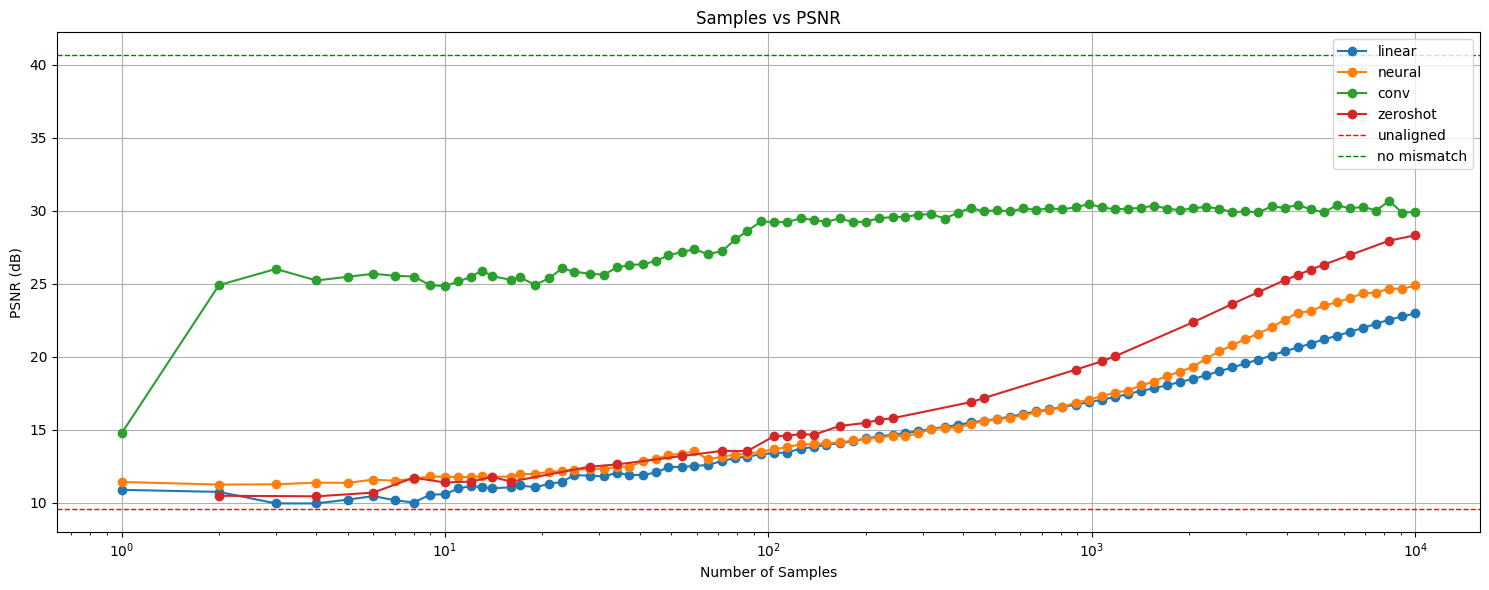

In [15]:
import matplotlib.pyplot as plt
import re

data = [("linear", text_linear), ("neural", text_neural), ("conv", text_conv), ("zeroshot", text_zeroshot)]

plt.figure(figsize=(15, 6))

# Iterate over all model blocks
for name, text in data:
    matches = re.findall(r'(\d+) samples got a PSNR of ([\d.]+)', text)
    samples = [int(m[0]) for m in matches]
    psnr = [float(m[1]) for m in matches]
    plt.plot(samples, psnr, marker='o', label=name)

plt.axhline(y=9.54, color='red', linestyle='--', linewidth=1, label='unaligned')
plt.axhline(y=40.66, color='green', linestyle='--', linewidth=1, label='no mismatch')

plt.title("Samples vs PSNR")
plt.xlabel("Number of Samples")
plt.ylabel("PSNR (dB)")
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
